# <center> Лабораторная работа №2. Object Detection. </center>

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc as sklearn_auc
import xmltodict, json
import torchvision
from PIL import Image
from tqdm.auto import tqdm
from torchvision.models.detection import _utils as det_utils
from urllib3 import request

In [5]:
def collate_fn(data):
    return tuple(zip(*data))

In [6]:
CPU = torch.device('cpu')
GPU = torch.device('cuda')

In [7]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    if isinstance(data, dict):
        return dict((k, to_device(v, device)) for k, v in data.items())
    return data.to(device, non_blocking=True)

In [8]:
class FruitDataset(Dataset):
    class2tag = {"apple": 1, "orange": 2, "banana": 3}

    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(1)
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            return transform(self.images[i]), self.annotations[i]
        return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [9]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou


def mmap(x, map_to: int):
    l = {53: 1, 52: 2, 55: 3, 1: 92}
    if x in l.keys():
        return 1 if map_to == 1 else l[x]
    return x


def evaluate_sample(target_pred, target_true, iou_threshold=0.5, map_to: int=0):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    # map classes from coco dataset
    if map_to:
      dt_labels = np.fromiter(map(lambda x: mmap(x, map_to), dt_labels), dtype=float)

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)
        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device, iou_threshold=0.0, map_to: int=0):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true, iou_threshold, map_to))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return sklearn_auc(recall, precision)

# Часть 1.  

In [37]:
def nms_(bboxes: torch.tensor, scores: torch.tensor, threshold_iou: float):
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()
    keep = []
    
    while len(order) > 0:
        idx = order[-1]

        keep.append(bboxes[idx])

        order = order[:-1]
        if len(order) == 0:
            break
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        w = xx2 - xx1
        h = yy2 - yy1
        
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h

        rem_areas = torch.index_select(areas, dim = 0, index = order) 

        union = (rem_areas - inter) + areas[idx]
        IoU = inter / union

        mask = IoU < threshold_iou
        order = order[mask]
    
    return keep


def filter_bboxes(prediction, target, confidence, iou_threshold, nms):
    suitable = []
    iou_passed = False
    bboxes, labels, scores = to_device(list(prediction.values()), CPU)
    if target:
      t_bboxes, t_labels = to_device(list(target.values()), CPU)

    if nms:
      bboxes = nms_(bboxes, scores, iou_threshold)

    for i in range(len(bboxes)):
        if iou_threshold != 0.0 and target and not nms:
            for j in range(len(t_bboxes)):
                if (labels[i] == t_labels[j]) and (intersection_over_union(bboxes[i].numpy(), t_bboxes[j].numpy()) > iou_threshold):
                    iou_passed = True
                    break
        else:
            iou_passed = True

        if iou_passed and (scores[i] > confidence):
            suitable.append(bboxes[i])

    return suitable


def draw_bboxes(image, prediction, target, confidence, iou_threshold, nms: bool = False):
    with torch.no_grad():
        width = 4
        color = (255,0,0)
 
        suitable_bbxs = filter_bboxes(prediction, target, confidence, iou_threshold, nms)

        if not suitable_bbxs:
            plt.imshow(np.transpose((image*255).to(torch.uint8).cpu().numpy(), axes=(1,2,0)))
            return

        suitable_bbxs = torch.stack(suitable_bbxs)
        img_with_bboxes = torchvision.utils.draw_bounding_boxes(image=(image*255).to(torch.uint8).cpu(),
                                                                boxes=suitable_bbxs,
                                                                width=width,
                                                                colors=color
                                                            ).permute(1,2,0)
        plt.imshow(img_with_bboxes)

In [25]:
model_names = ['SSD', 'RetinaNet', 'Faster R-CNN']

def get_model(name: str, num_classes=2, pretrained: bool=True, change_head: bool=False, device=CPU):
    models = {
        'Faster R-CNN': torchvision.models.detection.fasterrcnn_resnet50_fpn,
        'RetinaNet': torchvision.models.detection.retinanet_resnet50_fpn,
        'SSD': torchvision.models.detection.ssd300_vgg16
    }
    model = models[name](pretrained)
    
    if change_head:
      if name == 'Faster R-CNN':
          in_features = model.roi_heads.box_predictor.cls_score.in_features
          model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
      elif name == 'SSD':
          out_channels = det_utils.retrieve_out_channels(model.backbone, (300, 300))
          num_anchors = model.anchor_generator.num_anchors_per_location()
          model.head.classification_head = torchvision.models.detection.ssd.SSDClassificationHead(
              in_channels=out_channels,
              num_anchors=num_anchors,
              num_classes=num_classes
          )
      else:
          in_channels = model.head.classification_head.cls_logits.in_channels
          num_anchors = model.head.classification_head.num_anchors
          model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
              in_channels=in_channels,
              num_anchors=num_anchors,
              num_classes=num_classes,
              prior_probability=0.5
          )
    
    return to_device(model, device)

In [16]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Lambda(lambda e: (e/255).astype(np.float32)),
        torchvision.transforms.ToTensor(),
    ]
)

train_dataset = FruitDataset('/content/drive/MyDrive/Colab Notebooks/data/train', transform=transform)
val_dataset, train_dataset = random_split(train_dataset, [len(train_dataset)-round(len(train_dataset)*0.75), round(len(train_dataset)*0.75)])
test_dataset = FruitDataset('/content/drive/MyDrive/Colab Notebooks/data/test', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn)

## Задание 1.  
  
Все три детектора показывают схожие значения AUC, модели предтренированные, без смены головы.

In [17]:
for name in model_names:
  model = get_model(name, change_head=False, pretrained=True, device=GPU)
  print(f'Detector: {name}, AUC: {evaluate(model, test_dataloader, GPU, map_to=1)}')

Detector: Faster R-CNN, AUC: 0.7043046805555734
Detector: RetinaNet, AUC: 0.6852196223654575
Detector: SSD, AUC: 0.7115406751746594


Однако у RetinaNet и SSD очень много лишних bbox'ов с конфиденсом > 0.6, в отличие от Faster R-CNN

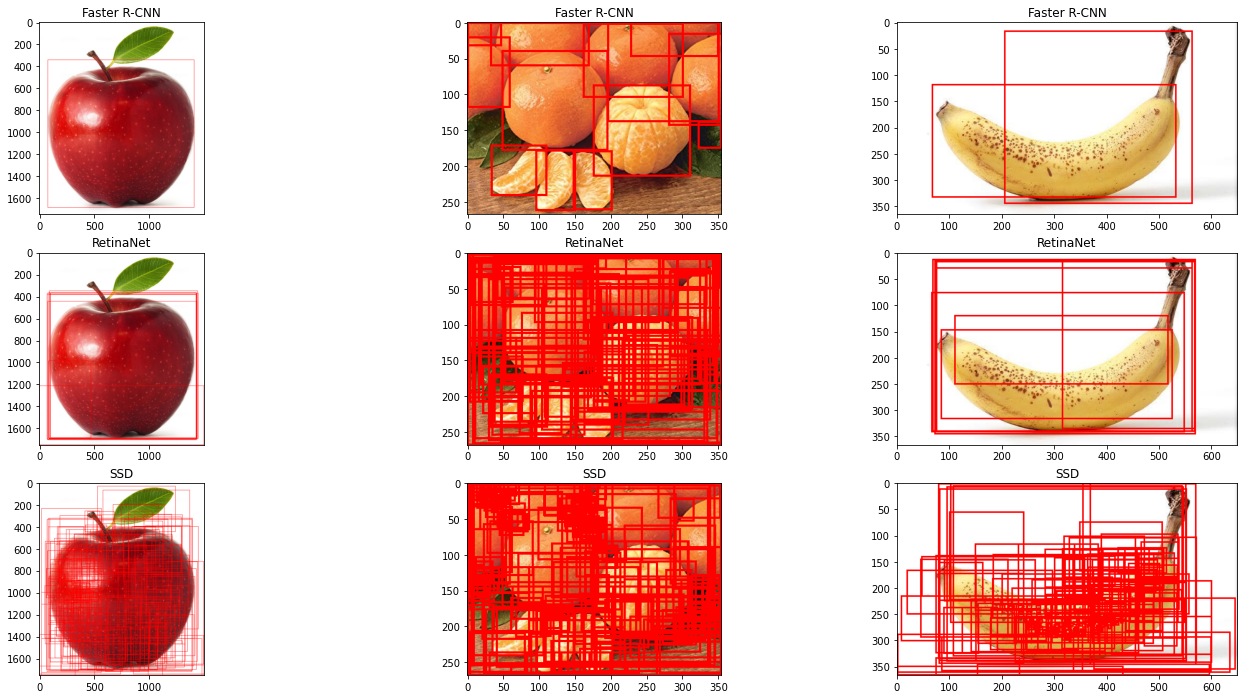

In [18]:
fig = plt.figure(figsize=(24, 12))
i = 0
img1, t1 = test_dataset[0]
img2, t2 = test_dataset[31]
img3, t3 = test_dataset[55]

targets = [t1, t2, t3]
imgs = [img1.to(GPU), img2.to(GPU), img3.to(GPU)]

for name in model_names:
  model = get_model(name, change_head=False, pretrained=True, device=GPU)
  model.eval()
  preds = model(imgs)

  for j in range(len(preds)):
      fig.add_subplot(3, 3, i + 1).title.set_text(name)
      draw_bboxes(imgs[j], preds[j], targets[j], confidence=0.6, iou_threshold=0.0)
      i += 1

## Задание 2.  
  
Для обучения выбрал SGD optimizer. Первоначальные попытки показали что эти сети очень чувствительны к значению lr, и если, например R-CNN отлично работает даже с lr = 0.05, то у RetinaNet при таких значениях происходит взрыв градиента, как и у SSD :)

In [15]:
def train_m(model,
            lr,
            epoches=5):

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    auc = 0
    
    for epoch in range(epoches):
        # train
        model.train()
        for x, y in train_dataloader:
            optimizer.zero_grad(set_to_none=True)
            x = to_device(x, GPU)
            y = to_device(y, GPU)
            losses = model(x, y)
            losses = sum(loss for loss in losses.values())
            losses.backward()
            optimizer.step()
            del x
            del y
        scheduler.step()

        # validate
        auc = evaluate(model, val_dataloader, GPU)
        print(f'Epoch: {epoch + 1}, AUC: {auc}')

    return auc

In [20]:
trained = dict()
pretrained_trained = dict()

Не предобученные модели:

In [24]:
for name in model_names:
    print('--------------------------------------------')
    model = get_model(name, pretrained=False, change_head=True, device=GPU)
    if name == 'Faster R-CNN':
        lr = 0.05
    elif name == 'RetinaNet':
        lr = 0.0005
    else:
        lr = 0.001
    print(f'Detector: {name}, pretrained=False, LR={lr}')
    print(f'Start AUC: {evaluate(model, val_dataloader, GPU)}')
    auc = train_m(model, lr, epoches=5)
    trained[name] = (model.to(CPU), auc)

--------------------------------------------
Detector: RetinaNet, pretrained=False, LR=0.0005
Start AUC: 0.030913216347704234
Epoch: 1, AUC: 0.47815650399137616
Epoch: 2, AUC: 0.6551938560971621
Epoch: 3, AUC: 0.6899141427162515
Epoch: 4, AUC: 0.6854020234761256
Epoch: 5, AUC: 0.7091317463250231
--------------------------------------------
Detector: Faster R-CNN, pretrained=False, LR=0.05
Start AUC: 0.3409114262553179
Epoch: 1, AUC: 0.6774410305497705
Epoch: 2, AUC: 0.8466710996281717
Epoch: 3, AUC: 0.9091457751464544
Epoch: 4, AUC: 0.9038037437099962
Epoch: 5, AUC: 0.9245320208290041
--------------------------------------------
Detector: SSD, pretrained=False, LR=0.0005
Start AUC: 0.06885801274856815
Epoch: 1, AUC: 0.24302467146090473
Epoch: 2, AUC: 0.2477332304118799
Epoch: 3, AUC: 0.3497684918224243
Epoch: 4, AUC: 0.418150456562523
Epoch: 5, AUC: 0.4813499385893315


Предобученные модели:

In [25]:
for name in model_names:
    print('--------------------------------------------')
    model = get_model(name, pretrained=True, change_head=True, device=GPU)
    if name == 'Faster R-CNN':
        lr = 0.05
    elif name == 'RetinaNet':
        lr = 0.0005
    else:
        lr = 0.001
    print(f'Detector: {name}, pretrained=True, LR={lr}')
    print(f'Start AUC: {evaluate(model, val_dataloader, GPU)}')
    auc = train_m(model, lr, epoches=5)
    pretrained_trained[name] = (model.to(CPU), auc)

--------------------------------------------
Detector: RetinaNet, pretrained=True, LR=0.0005
Start AUC: 0.31430743354220003
Epoch: 1, AUC: 0.4498129320477021
Epoch: 2, AUC: 0.5290869364382312
Epoch: 3, AUC: 0.5440614622404948
Epoch: 4, AUC: 0.5532758483931142
Epoch: 5, AUC: 0.5424013640775658
--------------------------------------------
Detector: Faster R-CNN, pretrained=True, LR=0.05
Start AUC: 0.1461303346600151
Epoch: 1, AUC: 0.9351814528738701
Epoch: 2, AUC: 0.9347416792615715
Epoch: 3, AUC: 0.9392323639614654
Epoch: 4, AUC: 0.9524347574425345
Epoch: 5, AUC: 0.947571934167603
--------------------------------------------
Detector: SSD, pretrained=True, LR=0.001
Start AUC: 0.6594843051749055
Epoch: 1, AUC: 0.7674599076403559
Epoch: 2, AUC: 0.8403749601688353
Epoch: 3, AUC: 0.8359247666845996
Epoch: 4, AUC: 0.9082344121336728
Epoch: 5, AUC: 0.9103592289769838


По итогам, дообученный Faster R-CNN оказался лучшим.

In [30]:
best_model, best_auc = pretrained_trained['Faster R-CNN']

## Задание 3. 

Перебор различных IoU's: [0.2, 0.4, 0.6, 0.7]



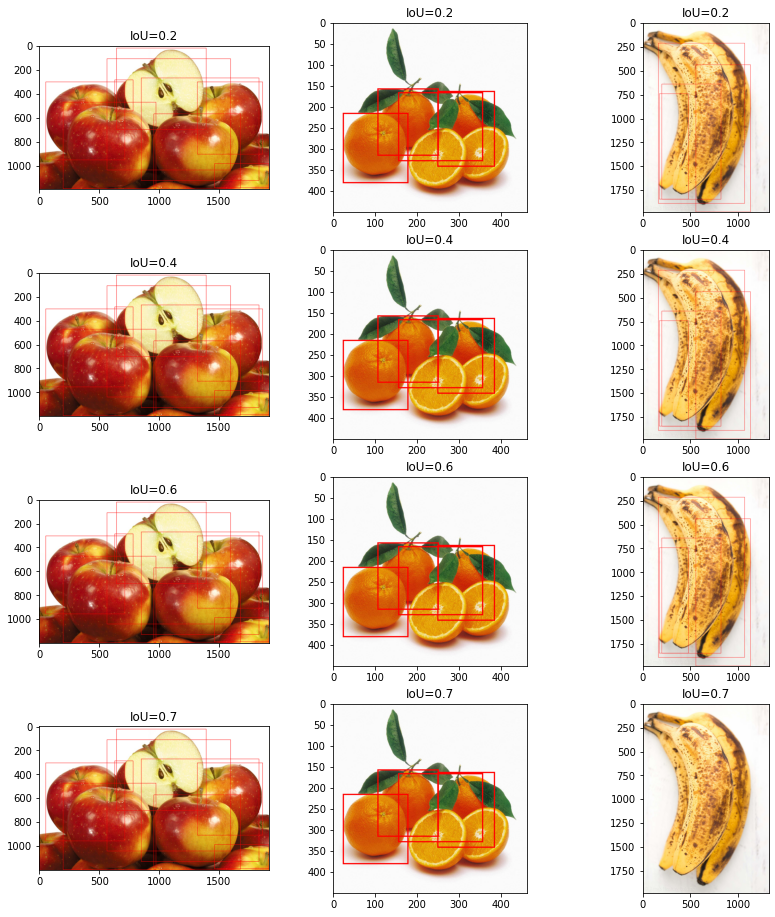

In [33]:
fig = plt.figure(figsize=(14,16))
ious = [0.2, 0.4, 0.6, 0.7]
model = best_model.to(GPU)
model.eval()

img1, t1 = test_dataset[8]
img2, t2 = test_dataset[28]
img3, t3 = test_dataset[52]

targets = [t1, t2, t3]
imgs = [img1.to(GPU), img2.to(GPU), img3.to(GPU)]
preds = model(imgs)

n = 0
for iou in ious:
    for i in range(3):
        fig.add_subplot(len(ious), 3, n + 1).title.set_text(f'IoU={iou}')
        draw_bboxes(imgs[i], preds[i], targets[i], confidence=0.0, iou_threshold=iou)
        n += 1

Перебор confidence: [0.1, 0.4, 0.7]

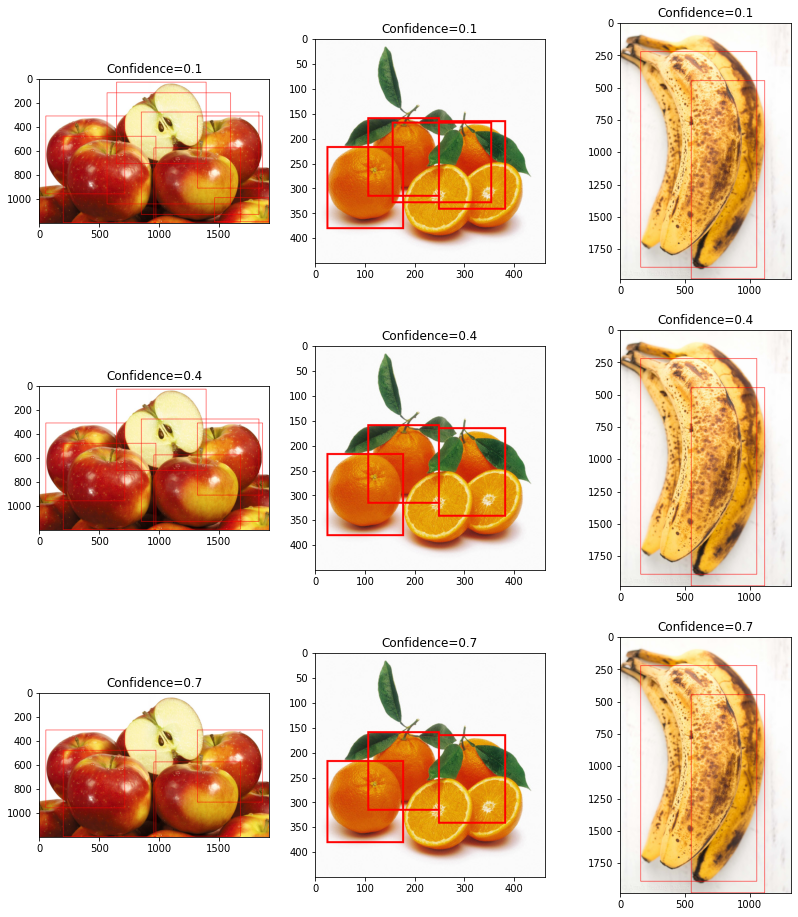

In [38]:
fig = plt.figure(figsize=(14,16))
confs = [0.1, 0.4, 0.7]
n = 0
for conf in confs:
    for i in range(3):
        fig.add_subplot(len(confs), 3, n + 1).title.set_text(f'Confidence={conf}')
        draw_bboxes(imgs[i], preds[i], targets[i], confidence=conf, iou_threshold=0.0)
        n += 1

## Задание 4.

In [41]:
import random
import io
from urllib.request import urlopen

apple = 'https://post.healthline.com/wp-content/uploads/2021/05/apples-1200x628-facebook.jpg'
banana = 'https://www.kingarthurbaking.com/sites/default/files/blog-featured/Best-Bananas-for-Banana-Bread-6_0.jpg'
orange = 'https://spoonuniversity.com/wp-content/uploads/sites/48/2015/05/dinazuret.jpg'
no_fruits = 'https://cdnimg.rg.ru/img/content/187/59/55/iStock-1093508248_t_650x433.jpg'

img1, t1 = test_dataset[random.randint(0, len(test_dataset))]
img2, t2 = test_dataset[random.randint(0, len(test_dataset))]

imgs_from_dataset = [img1, img2]
imgs_from_url = [
    transform(cv2.cvtColor(cv2.imdecode(np.fromiter(urlopen(apple).read(), dtype=np.int8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)),
    transform(cv2.cvtColor(cv2.imdecode(np.fromiter(urlopen(banana).read(), dtype=np.int8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)),
    transform(cv2.cvtColor(cv2.imdecode(np.fromiter(urlopen(orange).read(), dtype=np.int8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)),
    transform(cv2.cvtColor(cv2.imdecode(np.fromiter(urlopen(no_fruits).read(), dtype=np.int8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)),
]

imgs_from_dataset = to_device(imgs_from_dataset, GPU)
imgs_from_url = to_device(imgs_from_url, GPU)

model = best_model
model.eval()
ds_preds = model(imgs_from_dataset)
url_preds = model(imgs_from_url)

Картинки из датасета

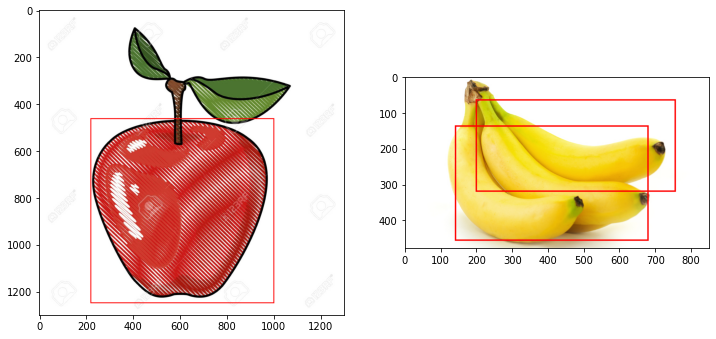

In [42]:
fig = plt.figure(figsize=(12,12))
for i in range(len(ds_preds)):
    fig.add_subplot(1, 2, i + 1)
    draw_bboxes(imgs_from_dataset[i], ds_preds[i], None, confidence=0.6, iou_threshold=0)

Картинки из интернета:
- Ноут тоже фрукт, потому что apple :)

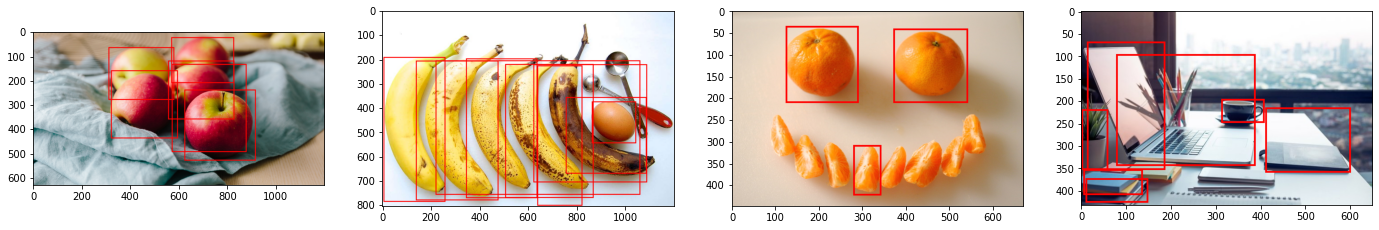

In [43]:
fig = plt.figure(figsize=(24,12))
for i in range(len(url_preds)):
    fig.add_subplot(1, 4, i + 1)
    draw_bboxes(imgs_from_url[i], url_preds[i], None, confidence=0.0, iou_threshold=0.0)

## Задание 5.  

In [71]:
img, t = test_dataset[2]
img = img.to(GPU)

model = best_model
model.eval()
pred = model([img])

Без NMS:

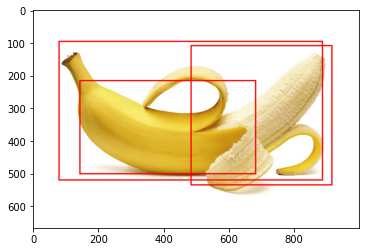

In [72]:
draw_bboxes(img, pred[0], t, confidence=0.0, iou_threshold=0.0, nms=False)

С NMS:

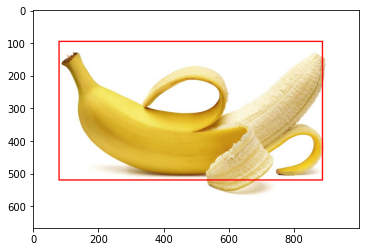

In [73]:
draw_bboxes(img, pred[0], t, confidence=0.0, iou_threshold=0.2, nms=True)

# Часть 2.  

In [12]:
class FruitDataset(Dataset):
    class2tag = {"apple": 1, "orange": 2, "banana": 3}

    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(self.class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            return self.transform(self.images[i]), self.annotations[i]
        return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)


transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Lambda(lambda e: (e/255).astype(np.float32)),
        torchvision.transforms.ToTensor(),
    ]
)

train_dataset = FruitDataset('/content/drive/MyDrive/Colab Notebooks/data/train', transform=transform)
val_dataset, train_dataset = random_split(train_dataset, [len(train_dataset)-round(len(train_dataset)*0.75), round(len(train_dataset)*0.75)])
test_dataset = FruitDataset('/content/drive/MyDrive/Colab Notebooks/data/test', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn)

## Задание 1

In [13]:
trained = dict()
pretrained_trained = dict()

Не предобученные модели:

In [26]:
for name in model_names:
    print('--------------------------------------------')
    model = get_model(name, pretrained=False, change_head=True, device=GPU, num_classes=4)
    if name == 'Faster R-CNN':
        lr = 0.05
    elif name == 'RetinaNet':
        lr = 0.00001
    else:
        lr = 0.0005
    print(f'Detector: {name}, pretrained=False, LR={lr}')
    print(f'Start AUC: {evaluate(model, val_dataloader, GPU)}')
    auc = train_m(model, lr, epoches=5)
    trained[name] = (model.to(CPU), auc)

--------------------------------------------
Detector: SSD, pretrained=False, LR=0.0005
Start AUC: 0.0690899349038685
Epoch: 1, AUC: 0.014521894374332876
Epoch: 2, AUC: 0.020060208510193512
Epoch: 3, AUC: 0.023501408372678823
Epoch: 4, AUC: 0.0247138065721239
Epoch: 5, AUC: 0.02530496644205987
--------------------------------------------
Detector: RetinaNet, pretrained=False, LR=1e-05
Start AUC: 0.023995371100520416
Epoch: 1, AUC: 0.12434725755046006
Epoch: 2, AUC: 0.12997903782079948
Epoch: 3, AUC: 0.13613975599172942
Epoch: 4, AUC: 0.13930694369895738
Epoch: 5, AUC: 0.14149605846480462
--------------------------------------------
Detector: Faster R-CNN, pretrained=False, LR=0.05
Start AUC: 0.021547234392554692
Epoch: 1, AUC: 0.09472883049213252
Epoch: 2, AUC: 0.26122679097344637
Epoch: 3, AUC: 0.42817850617122555
Epoch: 4, AUC: 0.694875587065708
Epoch: 5, AUC: 0.8250460381368332


Вообщем, с головой на 4 класса RetinaNet и SSD начинают совсем плохо работать, поэтому дальше буду использовать Faster R-CNN :)

Pre-trained Faster R-CNN:

In [27]:
model = get_model('Faster R-CNN', pretrained=True, change_head=True, device=GPU, num_classes=4)
print(f'Detector: Faster R-CNN, pretrained=True, LR={0.05}')
print(f'Start AUC: {evaluate(model, val_dataloader, GPU)}')
auc = train_m(model, 0.05, epoches=5)
pretrained_trained['Faster R-CNN'] = (model.to(CPU), auc)

Detector: Faster R-CNN, pretrained=True, LR=0.05
Start AUC: 0.14526680069239517
Epoch: 1, AUC: 0.7357942656604395
Epoch: 2, AUC: 0.9301748746714037
Epoch: 3, AUC: 0.9444921755830948
Epoch: 4, AUC: 0.9593646814649274
Epoch: 5, AUC: 0.9576205506711468


## Задание 2

In [28]:
best_model, best_auc = pretrained_trained['Faster R-CNN']

In [30]:
model = best_model.to(GPU)
model.eval()

img1, t1 = test_dataset[8]
img2, t2 = test_dataset[28]
img3, t3 = test_dataset[52]

targets = [t1, t2, t3]
imgs = [img1.to(GPU), img2.to(GPU), img3.to(GPU)]
preds = model(imgs)

Перебор различных IoU's: [0.2, 0.4, 0.6, 0.7]

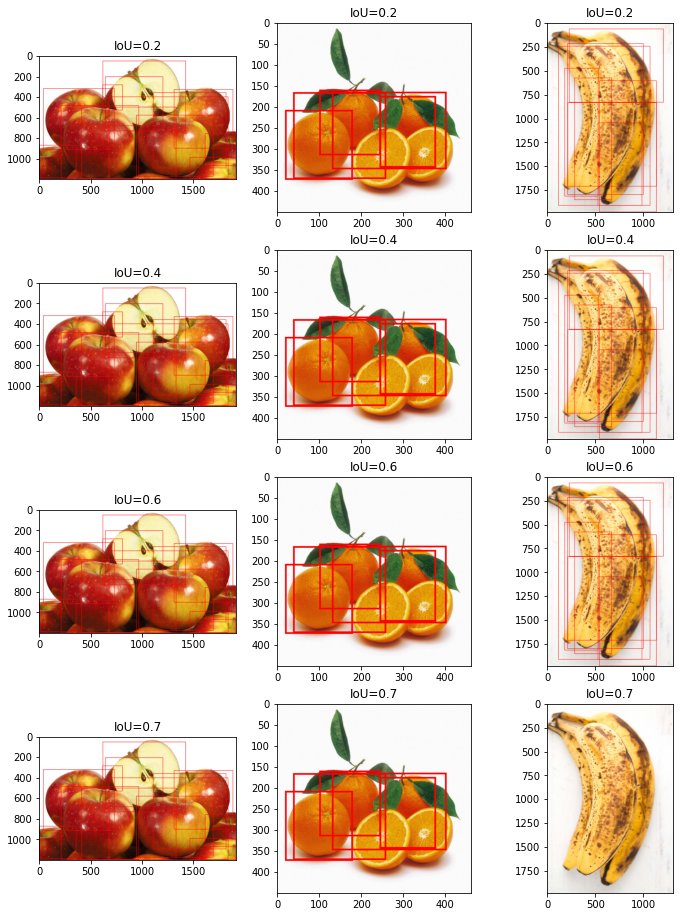

In [38]:
fig = plt.figure(figsize=(12,16))
ious = [0.2, 0.4, 0.6, 0.7]

n = 0
for iou in ious:
    for i in range(3):
        fig.add_subplot(len(ious), 3, n + 1).title.set_text(f'IoU={iou}')
        draw_bboxes(imgs[i], preds[i], targets[i], confidence=0.0, iou_threshold=iou)
        n += 1

Перебор confidence: [0.1, 0.4, 0.7]

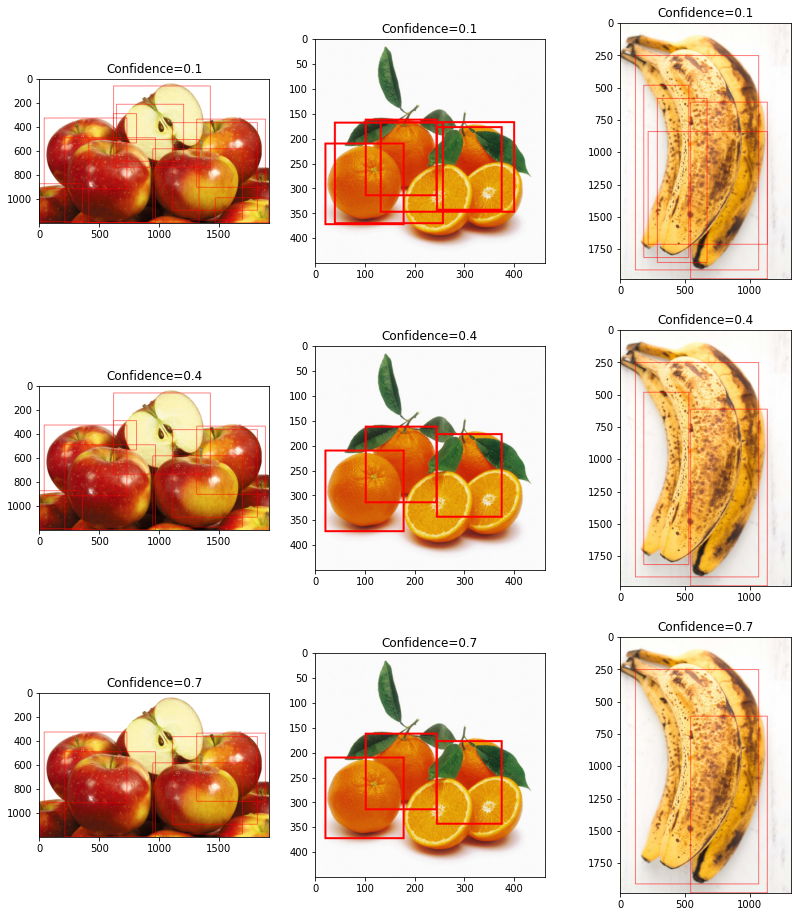

In [36]:
fig = plt.figure(figsize=(14,16))
confs = [0.1, 0.4, 0.7]
n = 0
for conf in confs:
    for i in range(3):
        fig.add_subplot(len(confs), 3, n + 1).title.set_text(f'Confidence={conf}')
        draw_bboxes(imgs[i], preds[i], targets[i], confidence=conf, iou_threshold=0.0)
        n += 1

## Задание 3

In [33]:
import random
import io
from urllib.request import urlopen

apple = 'https://post.healthline.com/wp-content/uploads/2021/05/apples-1200x628-facebook.jpg'
banana = 'https://www.kingarthurbaking.com/sites/default/files/blog-featured/Best-Bananas-for-Banana-Bread-6_0.jpg'
orange = 'https://spoonuniversity.com/wp-content/uploads/sites/48/2015/05/dinazuret.jpg'
no_fruits = 'https://cdnimg.rg.ru/img/content/187/59/55/iStock-1093508248_t_650x433.jpg'

img1, t1 = test_dataset[random.randint(0, len(test_dataset))]
img2, t2 = test_dataset[random.randint(0, len(test_dataset))]

imgs_from_dataset = [img1, img2]
imgs_from_url = [
    transform(cv2.cvtColor(cv2.imdecode(np.fromiter(urlopen(apple).read(), dtype=np.int8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)),
    transform(cv2.cvtColor(cv2.imdecode(np.fromiter(urlopen(banana).read(), dtype=np.int8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)),
    transform(cv2.cvtColor(cv2.imdecode(np.fromiter(urlopen(orange).read(), dtype=np.int8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)),
    transform(cv2.cvtColor(cv2.imdecode(np.fromiter(urlopen(no_fruits).read(), dtype=np.int8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)),
]

imgs_from_dataset = to_device(imgs_from_dataset, GPU)
imgs_from_url = to_device(imgs_from_url, GPU)

model = best_model
model.eval()
ds_preds = model(imgs_from_dataset)
url_preds = model(imgs_from_url)

Картинки из датасета:

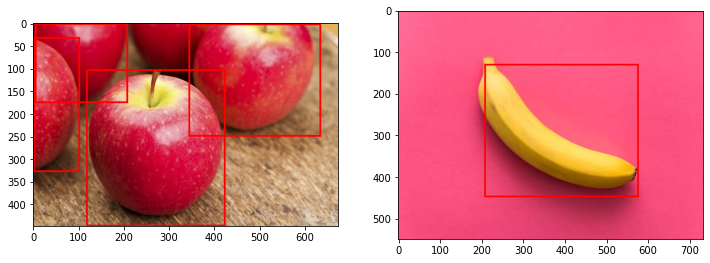

In [34]:
fig = plt.figure(figsize=(12,12))
for i in range(len(ds_preds)):
    fig.add_subplot(1, 2, i + 1)
    draw_bboxes(imgs_from_dataset[i], ds_preds[i], None, confidence=0.6, iou_threshold=0)

Картинки из интернета:
- (Mac по прежнему apple :) )

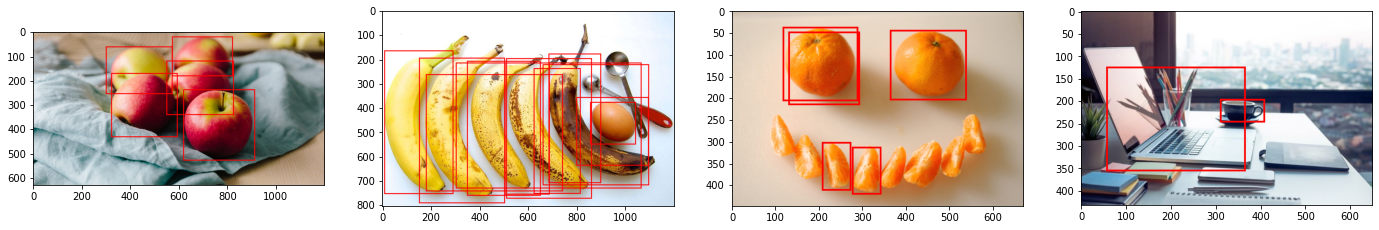

In [35]:
fig = plt.figure(figsize=(24,12))
for i in range(len(url_preds)):
    fig.add_subplot(1, 4, i + 1)
    draw_bboxes(imgs_from_url[i], url_preds[i], None, confidence=0.0, iou_threshold=0.0)

## Задание 4

In [45]:
img, t = test_dataset[50]
img = img.to(GPU)

model = best_model
model.eval()
pred = model([img])

Без NMS:

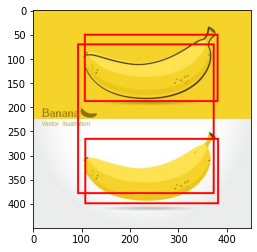

In [46]:
draw_bboxes(img, pred[0], t, confidence=0.0, iou_threshold=0.2, nms=False)

С NMS:

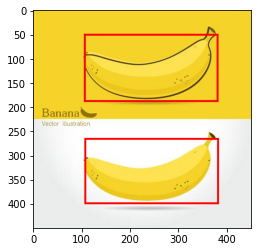

In [47]:
draw_bboxes(img, pred[0], t, confidence=0.0, iou_threshold=0.2, nms=True)

# Часть 3.

In [48]:
evaluate(best_model, test_dataloader, GPU)

0.9403753041002569